# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import  re
pd.set_option('display.max_columns', 50)
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Видим что изначально данные были склеены, разделили их сепаратором. При беглом осмотре набора данных можно предварительно оценить фронт работ: 
    1. По количеству значений в столбцах видно, что многих данных не хватает;
    2. многие столбцы можно будет привести к целочисленным значениям;
    3. В столбце с датой оставим только год, месяц, день - избыточная точность;

### Шаг 2. Предобработка данных

In [4]:
#Оценим масштаб пропущенных значений
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

###### Предварительно оценим по каким столбцам у нас пропуски и как бы мы могли их заполнить:
    1. ceiling_height - Исключим из данных строки с высотой потолка выше 6 метров. По опыту в Петербурге нет потолков выше. Округлим высоту потолков до 10 см (2.5, 2.6 и тд);
    2. floors_total - Исключим из анализа строки, где не указана высотность дома;
    3. living_area - Посчитаем среднее соотношение жилой площади к общей и вставим жилую площадь равную усредненному отношению к жилой площади;
    4. is_apartment - заменим NaN на 0, вероятно если не аппартаменты, то значение не указывали;
    5. kitchen_area - Посчитаем среднее соотношение кухни к общей и вставим площадь кухни равную усредненному отношению к жилой площади;
    6. balcony - заменим NaN на 0, вероятно если нет балкона, то значение не указывали;
    7. locality_name - удалим из данных, так как невозможно анализировать корректно без привязки к локации;
    8. airports_nearest - оставим пропуски, заменив на 0, нет возможности корректно заполнить данные;
    9. cityCenters_nearest - оставим пропуски, заменив на 0, нет возможности корректно заполнить данные;
    10. parks_around3000 - оставим пропуски, заменив на 0, нет возможности корректно заполнить данные;
    11. parks_nearest - оставим пропуски, заменив на 0, нет возможности корректно заполнить данные;
    12. ponds_around3000 - оставим пропуски, заменив на 0, нет возможности корректно заполнить данные;
    13. ponds_nearest - оставим пропуски, заменив на 0, нет возможности корректно заполнить данные;
    14. days_exposition - пропуски означают что объявление актуально, пропуски заменим на 0 и для себя этот факт запомним.

In [5]:
#Начнем с анализа высоты потолков, округлим все значения до 10 см, большая точность в данном параметре - избыточна.
data['ceiling_height'] = data['ceiling_height'].round(decimals=1)
#Посмотрим распределение значений, возможно увидим выпадающие или ошибочно заведенные, которые можно не потерять,
#а скорректировать
data['ceiling_height'].value_counts().head(60)

2.5      3792
2.6      3734
2.8      2247
2.7      1759
3.0      1241
3.2       407
3.1       285
2.9       213
3.3       182
3.5       157
3.4       138
3.6        73
4.0        48
2.4        38
3.7        38
3.8        37
3.9        19
4.2        14
2.0        11
27.0        8
25.0        7
4.5         7
4.4         6
2.3         5
4.1         5
8.0         3
2.2         2
4.7         2
32.0        2
5.3         2
4.9         1
5.2         1
4.6         1
20.0        1
24.0        1
6.0         1
1.0         1
22.6        1
4.3         1
8.3         1
4.8         1
1.8         1
14.0        1
5.0         1
5.6         1
10.3        1
26.0        1
100.0       1
5.5         1
5.8         1
27.5        1
1.2         1
Name: ceiling_height, dtype: int64

In [6]:
#Видим что есть значения равные, 32, 27, 25. Можно предположить что не стоит десятичный знак.
#обработаем данные, разделив значения больше 10 на 10. 
#Так же можно предположить, что значения до 2 метров человек перепутал и можно добавить 1 метр к таким значениям.
#Напишем функцию.
def celling_height(height):
    if height>=10:
        height /= 10
        return height
    if height<=2:
        height += 1
        return height
    return height

#Удалим заведомо выпадающее значение - потолок 100 метров
data = data.loc[data['ceiling_height'] != 100]
#Применим функцию к столбцу
data['ceiling_height'] = data['ceiling_height'].apply(celling_height)

Из гистограммы видно что основные значения выпадают практически на один диапазон. Поэтому заменим пропущенные значения средним значением округленным до десятичного знака.

In [7]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median().round(decimals=1))
#Проверим количество пропусков по столбцу ceiling_height
data['ceiling_height'].isna().sum()

0

In [8]:
#В исходных данных столбцы floors_total представленны в вещественном виде. 
#Этажность здания не может быть не целым числом, переведем их в целочисленный тип.
#Удалим строки с пропусками, где не указана этажность дома
data.dropna(subset=['floors_total'], inplace=True)
data['floors_total'] = data['floors_total'].astype('int')
#Проверим количество пропусков по столбцу floors_total
data['floors_total'].isna().sum()

0

In [9]:
#Площадь жилой площади заполним следующим образом:
#Посчитаем среднее соотношение жилой площади к общей и вставим жилую площадь равную 
#усредненному отношению к жилой площади
data['living_area_ratio'] = data['living_area'] / data['total_area']
data['living_area'] = data['living_area'].fillna(data['total_area'] * data['living_area_ratio'].mean().round(decimals=1))
#Обновим значения в столбце с отношением жилой площади к общей площади
data['living_area_ratio'] = data['living_area'] / data['total_area']
#Проверим количество пропусков по столбцу living_area
data['living_area'].isna().sum()

0

In [10]:
#is_appartmen предполагаем что, если нет значений, то это не аппартаменты - заменим на 0
data['is_apartment'] = data['is_apartment'].fillna(0)
data['is_apartment'].isna().sum()

0

In [11]:
#balcony предполагаем что, если нет значений, то нет балкона - заменим на 0
data['balcony'] = data['balcony'].fillna(0)
#Поменяем тип на целочисленный, не бывает дробного количества балконов
data['balcony'] = data['balcony'].astype('int')
data['balcony'].isna().sum()

0

In [12]:
#Площадь кухни заполним следующим образом:
#Посчитаем среднее соотношение кухни к общей и вставим площадь кухни равную 
#усредненному отношению к жилой площади
#Если квартира-студия, то площадь кухни равна 0.
data['kitchen_area_ratio'] = data['kitchen_area'] / data['total_area']
data.loc[data['studio']==True, 'kitchen_area'] = 0
data['kitchen_area'] = data.loc[data['studio']==False, 'kitchen_area'] = data['kitchen_area'].fillna(data['total_area'] * data['kitchen_area_ratio'].mean().round(decimals=1))
#Обновим значения в столбце с отношением площади кухни к общей площади
data['kitchen_area_ratio'] = data['kitchen_area'] / data['total_area']
#Проверим количество пропусков по столбцу living_area
data['kitchen_area'].isna().sum()

0

In [13]:
#Удалим пропуски без обозначения локации
data.dropna(subset=['locality_name'], inplace=True)

#airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest   
#обнулим данные пропуски, так как нет возможности заполнить эти расстояния - не достаточно данных, нет фактуры
#Переведем тип данных в целочисленный - избыточная точность
data['airports_nearest'] = data['airports_nearest'].fillna(0)
data['airports_nearest'] = data['airports_nearest'].astype('int')
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('int')
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['parks_nearest'] = data['parks_nearest'].fillna(0)
data['parks_nearest'] = data['parks_nearest'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)
data['ponds_nearest'] = data['ponds_nearest'].astype('int')
data['days_exposition'] = data['days_exposition'].fillna(0)
#Поменяем тип данных на целочисленный у стоимости квартиры и у срока размещения объявления
data['last_price'] = data['last_price'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')
#Поменяем тип данный у признака аппартаментов на булевый
data['is_apartment'] = data['is_apartment'].astype('bool')

In [14]:
#Поменяем формат даты подачи объявления, оставим только день/месяц/год
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23564 entries, 0 to 23698
Data columns (total 24 columns):
total_images            23564 non-null int64
last_price              23564 non-null int64
total_area              23564 non-null float64
first_day_exposition    23564 non-null datetime64[ns]
rooms                   23564 non-null int64
ceiling_height          23564 non-null float64
floors_total            23564 non-null int64
living_area             23564 non-null float64
floor                   23564 non-null int64
is_apartment            23564 non-null bool
studio                  23564 non-null bool
open_plan               23564 non-null bool
kitchen_area            23564 non-null float64
balcony                 23564 non-null int64
locality_name           23564 non-null object
airports_nearest        23564 non-null int64
cityCenters_nearest     23564 non-null int64
parks_around3000        23564 non-null int64
parks_nearest           23564 non-null int64
ponds_around3000     

### Шаг 3. Посчитайте и добавьте в таблицу

In [16]:
#Посчитаем стоимость квадратного метра для каждого объекта недвижимости
data['price_per_quad'] = data['last_price'] / data['total_area']
#Сделаем новый столбец целочисленным
data['price_per_quad'] = data['price_per_quad'].astype('int')

#Добавим в таблицу столбцы неделя / месяц / год
data['week_day'] = data['first_day_exposition'].dt.weekday_name
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

#Добавим столбец в этажи первый / последний / другой
data['floor'] = data['floor'].replace(1, 'первый')
data.loc[data['floor']==data['floors_total'], 'floor'] = 'последний'
data.loc[(data['floor']!='первый') & (data['floor']!='последний'), 'floor'] = 'другой'

#соотношение жилой и общей площади, а также отношение площади кухни к общей мы посчитали ранее, 
#значения сохранены в столбцах living_area_ratio и kitchen_area_ratio

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

#### Изучите следующие параметры: площадь, цена, число комнат, высота потолков. Постройте гистограммы для каждого параметра.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeb37e5320>]],
      dtype=object)

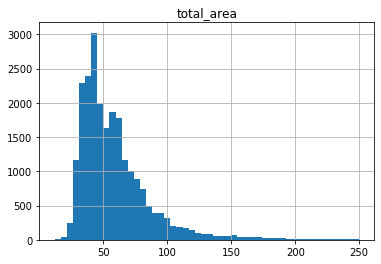

In [17]:
#Изучим распределение предложений разной площади, исключим "непрелично" большие квартиры
data.query('total_area<250').hist('total_area', bins=50)

Можем обратить внимание, что основное количество предложений на рынке - от 25 до 100 кв. м.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeb349a048>]],
      dtype=object)

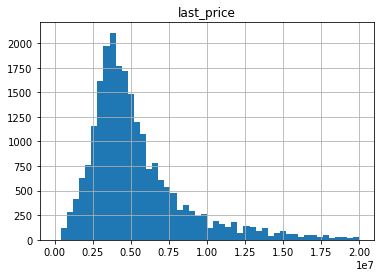

In [18]:
#Изучим распределение предложений разной стоимости, исключим запредельные стоимости
data.query('last_price<20000000').hist('last_price', bins=50)

Можем обратить внимание, что основное количество предложений на рынке - от 1.5 млн до 10 млн.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeb346cda0>]],
      dtype=object)

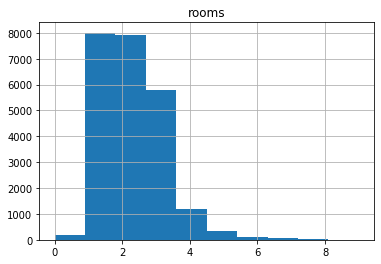

In [19]:
#Изучим распределение предложений по количеству комнат, исключим запредельные стоимости
data.query('rooms<10').hist('rooms', bins=10)

Можем обратить внимание, что основное количество предложений на рынке - от 1 до 3 комнат.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeb29c4f60>]],
      dtype=object)

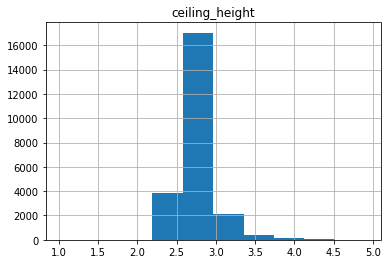

In [20]:
#Изучим распределение предложений по высоте потолков, исключим запредельные стоимости
data.query('ceiling_height<5').hist('ceiling_height', bins=10)

Можем обратить внимание, что основное количество предложений на рынке - стандартной высоты - 2.6, 2.7 метровыми потолками.

#### Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

0     3171
45     879
60     538
7      234
30     208
Name: days_exposition, dtype: int64

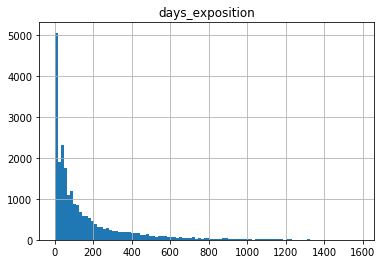

In [21]:
#Изучим время продажи квартир, построим гистограму и оценим распредление
data.hist('days_exposition', bins=100)
data['days_exposition'].value_counts().head(5)

Можем обратить внимание, что основной вклад в распределение у нас при значении 0. 
0 у нас установлен в строках, объявления по которым актуальны и еще не закрыты. Для корректного отображения статистики 
отсекем все значения равные 0 и построим гистограмму еще раз.
Так же можем обратить внимание, что значений больше 600 очень мало, уберем и их для наглядности распределения.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeb29eca90>]],
      dtype=object)

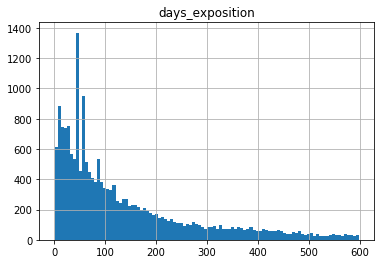

In [22]:
data.query('600>days_exposition>0').hist('days_exposition', bins=100)

In [23]:
#Посчитаем среднее арифметическое и медиану срока размещения объявления
print('Среднее арифметическое:{: .1f}'.format(data['days_exposition'].mean()))
print('Медиана:{: .1f}'.format(data['days_exposition'].median()))

Среднее арифметическое: 156.4
Медиана: 73.0


По полученным данным можно сделать вывод, что активность на рынке недвижимости в Ленинградской области довольна высокая. Основная масса сделок закрывается в промежутке до полугода. Если сделка не закрыта дольше чем пол года, то данную сделку можем считать необычно долгой (Причины долгой продажи надо рассматривать отдельно: неудачная локация, слишком большая площадь/цена и т.д.).
Так как основное количество сделок у нас сосредоточено в начале диапазона, то можно сделать выводы, что квартиры продаются довольно быстро и сделка, которая была совершена в первую неделю, можно было считать как необычайно быстрая.

Так же мы видим два выброса в районе 45, 60 дней, которые явно выбиваются из обей картины. Можно предположить что на таких круглых датах объявления были закрыты системой в автоматическом режиме, по истечению срока давности.
Разберемся с ними дальше.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeb29cbda0>]],
      dtype=object)

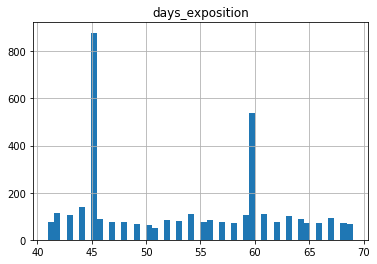

In [24]:
#Посмотрим на выбросы 45 и 100 поближе, построим гистограмму
data.query('70>days_exposition>40').hist('days_exposition', bins=50)

Предположительно, это всё-таки не выбросы, а реально закрытые автоматически системой объявления. Не правильно будет их размазывать - это исказит данные.

#### Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года.

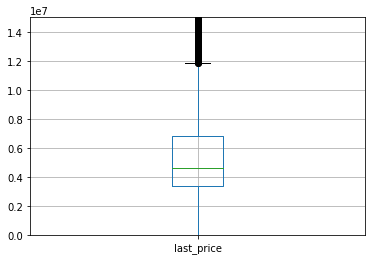

In [25]:
#При помощи диаграммы размаха определим диапазон, который будем анализировать

#Определимся с критерием по парметру last_price
plt.ylim(0, 15000000)
data.boxplot('last_price')

По параметру last_price принимаем что основная масса значений лежит в интервале до 12 млн.

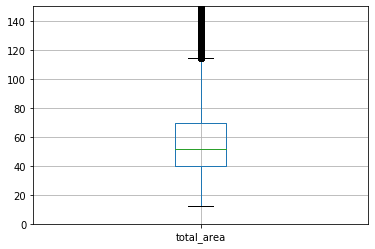

In [26]:
#При помощи диаграммы размаха определим диапазон, который будем анализировать

#Определимся с критерием по парметру total_area
plt.ylim(0, 150)
data.boxplot('total_area')

По параметру total_area принимаем что основная масса значений лежит в интервале до 120 кв. м.

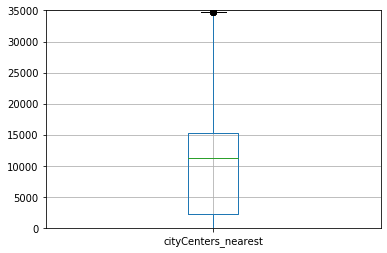

In [27]:
#При помощи диаграммы размаха определим диапазон, который будем анализировать

#Определимся с критерием по парметру cityCenters_nearest.
plt.ylim(0, 35000)
data.boxplot('cityCenters_nearest')

По параметру cityCenters_nearest принимаем что основная масса значений лежит не дальше 35000

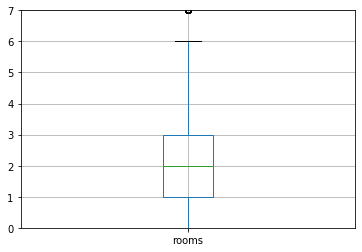

In [28]:
#При помощи диаграммы размаха определим диапазон, который будем анализировать

#Определимся с критерием по парметру rooms
plt.ylim(0, 7)
data.boxplot('rooms')

По параметру rooms принимаем что основная масса значений лежит не больше 6

0.6536759424479043


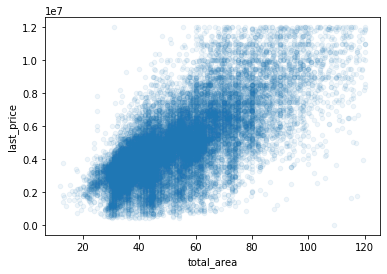

In [29]:
#определим зависимость стоимость квартиры от количества квадратным метров общей площади.
#Построим граффик рассеяния по двум параметрам: last_price и total_area
#Для наглядности отсекем выпадающие значения, где мало данных.
#Так же проверим коэффициент корреляции параметров
print(data['total_area'].corr(data['last_price']))
data.query('total_area<=120 and last_price<=12000000 and rooms<=6 and cityCenters_nearest<=35000').plot(x='total_area', y='last_price', kind='scatter', alpha=0.07)

По данной диаграмме рассеяния явно просматривается линейная зависимость стоимости квартиры от количества квадратных метров, что подтверждает и коэффициент корреляции

0.36323544098951444


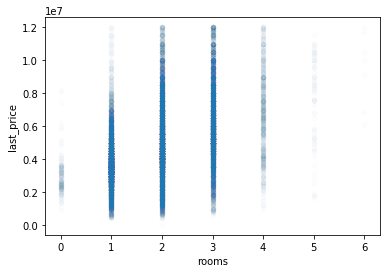

In [30]:
#определим зависимость стоимость квартиры от количества комнат.
#Построим граффик рассеяния по двум параметрам: last_price и rooms
#Не будем учитывать квартиры больше 120 кв. метров и не больше 6 комнат
#Так же проверим коэффициент корреляции параметров
print(data['rooms'].corr(data['last_price']))
data.query('total_area<=120 and last_price<=12000000 and rooms<=6 and cityCenters_nearest<=35000').plot(x='rooms', y='last_price', kind='scatter', alpha=0.01)

По данному распределению видно, основное количество объявлений укладывается в 1-3 комнаты и распредление имеет прямую линейную зависимость, причем с возрастающей вилкой стоимости (прямая пропорция минимальной и максимальной цены).

-0.05056701159603349


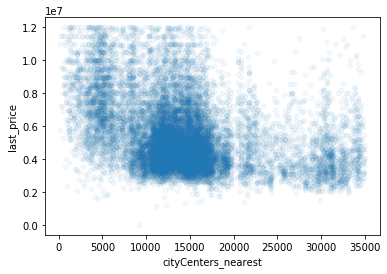

In [57]:
#определим зависимость стоимость квартиры от удаленности от центра города
#Построим граффик рассеяния по двум параметрам: last_price и cityCenters_nearest
#Не будем учитывать квартиры больше 120 кв. метров и не дальше 35 км
#Так же проверим коэффициент корреляции параметров
print(data['cityCenters_nearest'].corr(data['last_price']))
data.query('total_area<=120 and last_price<=12000000 and rooms<=6 and 0<cityCenters_nearest<=35000').plot(x='cityCenters_nearest', y='last_price', kind='scatter', alpha=0.05)

По данному распределению можно увидеть, что стоимость зависит от удаленности от центра, что противоречит коэффициенту корреляции равный практически 0.
Видно что основное количество предложений сосредоточено на расстоянии 8-18 км от центра города.
Так же имеется огромное количество значений в значении 0 - мы определили эти значения, где были пропуски в данных и понимаем что это объявления в основной своей массе не из Санкт-Петербурга и не корректно их включать в график рассеяния.

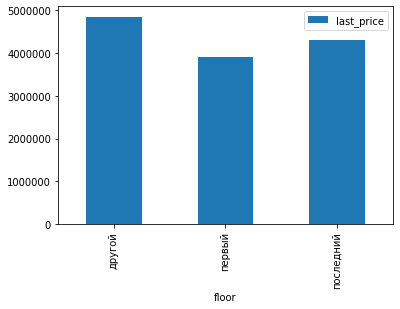

In [32]:
#Проверим зависимость стоимости квартиры от этажа (первый/последний/другой)
#сначала агрегируем данные, а потом построим график.
data_floors = data.pivot_table(index='floor', values='last_price', aggfunc='median')
data_floors['floor']=data_floors.index
data_floors.plot(x='floor', y='last_price', kind='bar')

По данному графику видно, что квартиры на первом этаже в среднем стоят дешевле чем квартиры на других этажах, а квартиры на последнем этаже стоят дороже квартир на первых этажах, но дешевле других этажей.

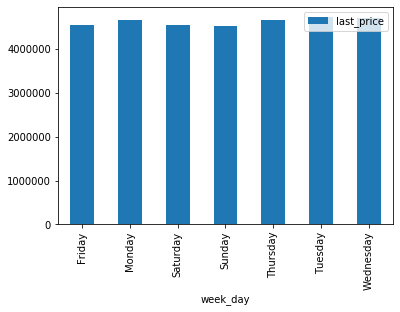

In [33]:
#Проверим зависимость стоимости квартиры от дня недели, месяца и года
#сначала агрегируем данные, а потом построим графики
data_weekday = data.pivot_table(index='week_day', values='last_price', aggfunc='median')
data_month = data.pivot_table(index='month', values='last_price', aggfunc='median')
data_year = data.pivot_table(index='year', values='last_price', aggfunc='median')
data_weekday['week_day']=data_weekday.index
data_month['month']=data_month.index
data_year['year']=data_year.index

#Посмотрим на график зависимости средней стоимости от дня недели закрытия заявки
data_weekday.plot(x='week_day', y='last_price', kind='bar')

Явно выраженной зависимости от дня недели не наблюдается, всё довольно таки равномерно.

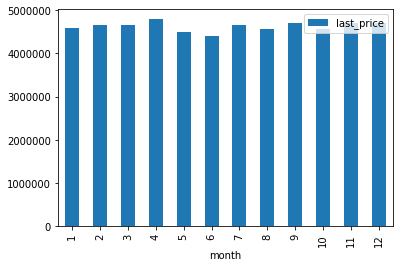

In [34]:
#Проверим зависимость стоимости квартиры от месяца
data_month.plot(x='month', y='last_price', kind='bar')

По разспределению средней стоимости по месяцам можно увидель небольшую просадку в конце весны-начале лета.

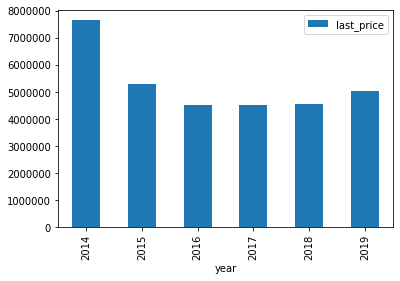

In [35]:
#Проверим зависимость стоимости квартиры от года
data_year.plot(x='year', y='last_price', kind='bar')

По распределению средней стоимости по годам есть явно выраженное падение средней стоимости после 2014 года, достигнув минимума в 2016 году, что связано с резким ростом курса доллара и с общим падением экономики в стране.
Так же можно заметить небоольшой рост средней стоимсоти недвижимости в 2019 году, по сравнению с предыдущими годами

#### Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.

In [36]:
#Построим сначала выборки по необходимым параметрам, 
#среднюю стоимость квадратного метра мы расчитали ранее
data_top10_counts = data.pivot_table(index='locality_name', values='last_price', aggfunc=['count', 'mean'])
data_top10_quad = data.pivot_table(index='locality_name', values='price_per_quad', aggfunc='mean')
#Объединим таблицы
data_top10 = data_top10_counts.join(data_top10_quad)
#Переименуем столбцы
data_top10.columns = ['count', 'mean', 'price_per_quad']
#Отсортируем по убыванию и ТОП-10 переназначим нашей финальной таблице
data_top10 = data_top10.sort_values(by='count', ascending=False).head(10)
data_top10

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,count,mean,price_per_quad
locality_name,,,
Санкт-Петербург,15650,8.064452e+06,114837.435080
посёлок Мурино,520,3.671211e+06,85672.803846
посёлок Шушары,439,4.109809e+06,78550.883827
Всеволожск,398,3.789068e+06,68654.007538
Пушкин,369,6.469036e+06,103125.373984
Колпино,338,3.964021e+06,75424.150888
посёлок Парголово,327,4.488075e+06,90175.489297
Гатчина,307,3.488337e+06,68745.693811
деревня Кудрово,299,4.234158e+06,92473.086957


In [37]:
#Определим самую высокую стоимость жилья
max_price = data.max()
print('Самая высокая цена недвижимости в', max_price['locality_name'], 'стоимостью', max_price['last_price'])
#Определим самую высокую стоимость жилья
min_price = data.min()
print('Самая низкая цена недвижимости в', min_price['locality_name'], 'стоимостью', min_price['last_price'])

Самая высокая цена недвижимости в село Шум стоимостью 763000000
Самая низкая цена недвижимости в Бокситогорск стоимостью 12190


#### Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


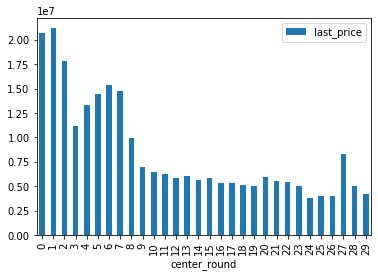

In [38]:
#Создадим отдельный сет с предложениями квартир только в Санкт-Петербурге
data_spb = data.loc[data['locality_name']=='Санкт-Петербург']

#Разделим расстояние в метрах, округлим до целого и перевелем в целочисленный тип.
data_spb['center_round'] = data_spb['cityCenters_nearest'] /1000
data_spb['center_round'] = data_spb['center_round'].round(0).astype('int')
data_sbp_mean = data_spb.pivot_table(index='center_round', values='last_price', aggfunc='mean')
data_sbp_mean['center_round'] = data_sbp_mean.index
data_sbp_mean.plot(x='center_round', y='last_price', kind='bar')

По данному графику распределения средней цены от удаленности от центра можно увидеть, что средняя стоимсоть сильно снижается на расстоянии 3 км и дальше.
Поэтому определим центральной зоной радиус в 3 км.
Дальше 3 км идет рост цены - это близкие спальные районы с развитой инфраструктурой, дальше 9 км идут дальние спальные районы

#### Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

In [39]:
#Создадим отдельный сет с предложениями квартир только в центре Санкт-Петербурга
data_spb_center = data_spb.loc[data_spb['center_round']<=3]

Средняя площадь квартир в центре:  98.0
Средняя площадь квартир во всем городе:  64.7


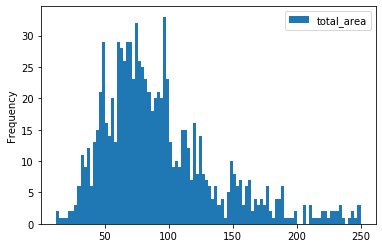

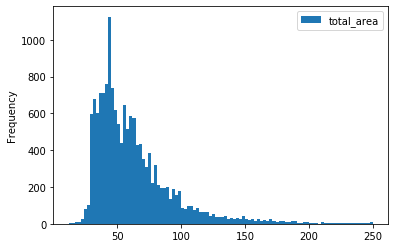

In [40]:
#Изучим различные различные параметры:
#Изучим распределение площади
print('Средняя площадь квартир в центре: ', data_spb_center['total_area'].mean().round(1))
print('Средняя площадь квартир во всем городе: ', data_spb['total_area'].mean().round(1))
data_spb_center.query('total_area<=250').plot(y='total_area',bins=100,kind='hist')
data_spb.query('total_area<=250').plot(y='total_area',bins=100,kind='hist')

В центре города распределение заявок по суммарной площади в целом отличается от общей картины: распределение сдвинуто в сторнону большей площади и в целом средняя площадь квартир в центре больше, чем в целом по городу.

Средняя стоимость квартир в центре:  16289700.7
Средняя стоимост квартир во всем городе:  8064452.2


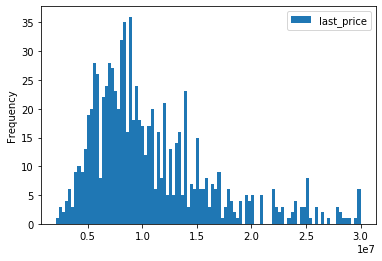

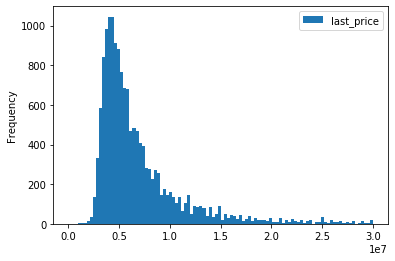

In [41]:
#Изучим распределение стоимости
print('Средняя стоимость квартир в центре: ', data_spb_center['last_price'].mean().round(1))
print('Средняя стоимост квартир во всем городе: ', data_spb['last_price'].mean().round(1))
data_spb_center.query('last_price<=30000000').plot(y='last_price',bins=100,kind='hist')
data_spb.query('last_price<=30000000').plot(y='last_price',bins=100,kind='hist')

В центре города распределение заявок по стоимости в целом отличается от общей картины: распределение сдвинуто в сторнону большей стоимости и в целом средняя стоимость квартир в центре значительно больше, чем в целом по городу. Так же предложения по стоимости превышающую 20 млн руб - не редкость.

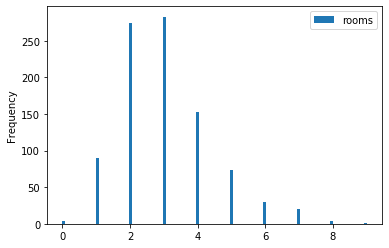

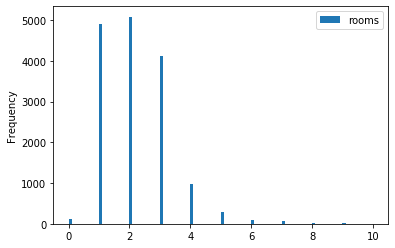

In [42]:
#Изучим распределение по количеству комнат
data_spb_center.query('rooms<=10').plot(y='rooms',bins=100,kind='hist')
data_spb.query('rooms<=10').plot(y='rooms',bins=100,kind='hist')

В центре города распределение заявок по количеству комнат так же отличается от общей картины, меньше, в целом, предложений однокомнатных квартир, акцент смещен на 3, 4 и 5  комнатные квартиры, так же достаточно предложений и квартир больше 5 комнат

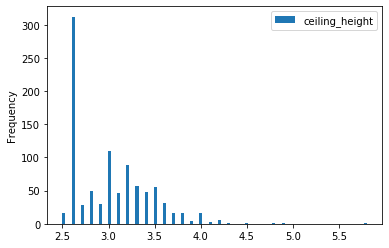

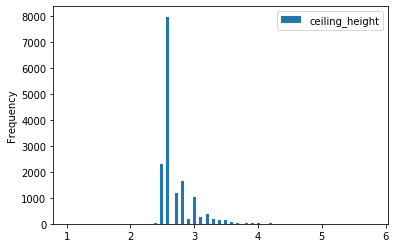

In [43]:
#Изучим распределение по высоте потолков
data_spb_center.query('ceiling_height<6').plot(y='ceiling_height',bins=100,kind='hist')
data_spb.query('ceiling_height<6').plot(y='ceiling_height',bins=100,kind='hist')

В центре города распределение заявок по высоте потолков также различается, в центре гораздо больше предложений с высотой потолка 3+ метра.

##### выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления)

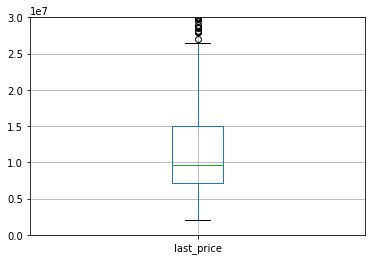

In [44]:
#Определим критерий last_price для центра
plt.ylim(0, 30000000)
data_spb_center.boxplot('last_price')

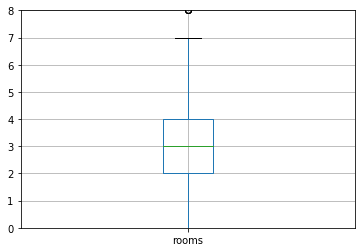

In [45]:
#Определим критерий rooms для центра
plt.ylim(0, 8)
data_spb_center.boxplot('rooms')

0.2519585752546591


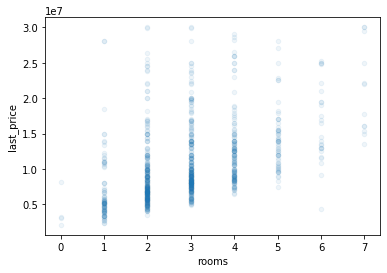

In [46]:
#Изучим как число комнат влияет на стоимость квартиры
print(data_spb_center['rooms'].corr(data_spb_center['last_price']))
data_spb_center.query('total_area<=400 and last_price<=30000000 and rooms<=7').plot(x='rooms', y='last_price', kind='scatter', alpha=0.07)

Зависимость стоимости квартиры от количество комнат прямопропорциональна, но количество предложений на квартиры больше 3 комнат снижаются с ростом количества комнат

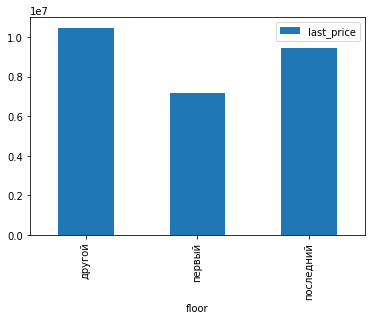

In [47]:
#Проверим зависимость стоимости квартиры от этажа (первый/последний/другой)
#сначала агрегируем данные, а потом построим график.
data_spb_center_floors = data_spb_center.pivot_table(index='floor', values='last_price', aggfunc='median')
data_spb_center_floors['floor']=data_spb_center_floors.index
data_spb_center_floors.plot(x='floor', y='last_price', kind='bar')

Зависимость этажности аналогичная со средней по городу, меньше всегов цене квартиры на 1 этаже, квартиры на последних этажах дороже первых но дешевле любого другого

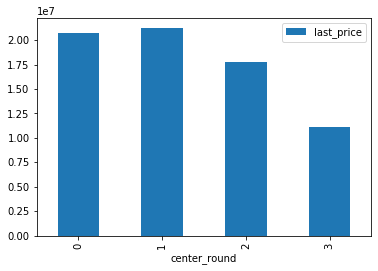

In [48]:
#Изучим как число комнат влияет на стоимость квартиры
#print(data_spb_center['rooms'].corr(data_spb_center['last_price']))
data_spb_center_mean = data_spb_center.pivot_table(index='center_round', values='last_price', aggfunc='mean')
data_spb_center_mean['center_round'] = data_spb_center_mean.index
data_spb_center_mean.plot(x='center_round', y='last_price', kind='bar')

Зависимость расстояния от центра обратнопропорциональная и на расстоянии в 3 км стоимость снижается значительно, по сравнению с 2х километровым удалением.

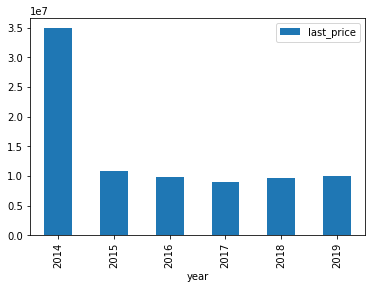

In [49]:
#Проверим зависимость стоимости квартиры от года
data_spb_center_year = data_spb_center.pivot_table(index='year', values='last_price', aggfunc='median')
data_spb_center_year['year']=data_year.index
data_spb_center_year.plot(x='year', y='last_price', kind='bar')

Зависимость стоимости квартиры в центре по годам очень показательна: После наступления кризиса 2014 года, стоимость недвижимости в центре Петербурга рухнула почти в 3.5 раза и до сих пор не восстановила своей докризисной стоимости.
Начиная с 2017 года имеется незначительный тренд на повышение.

### Шаг 5. Общий вывод

После отсистки и проведения анализа исходных данных, можно подвести итог и сделать определенные выводы о состоянии рынка недвижимости в г. Санкт-Петербурге и соседних населенных пунктах:
    1. Рынок недвижимости в Санкт-Петербурге на порядод больше рынка недвижимости всех остальных населенных пунктов в совокупности;
    2. Рынок недвижимости очень разнообразен на предлагаемые типы недвижимости, но в то же время и имеются определенные закономерности. В частности в центре Петербурга доминирует жилой фонд с высокими потолками и большей площадью квартир (наследие имперской эпохи), чем в остальной части города (типовая советская застройка).
    3. Стоимоть недвижимости зависит от многих параметров, особенно от площади и количества комнат в квартире, что доволно предсказуемо.
    4. Независимо от района города подтверждается одна и та же тенденция: квартиры на первых этажах имеют наименьшую стоимость, по сравнению с квартирами вышей этажности, так же квартиры на последних этажах имеют некий дискон, по сравнению с кварирами в середине дома.
    5. По стоимости квартир в Петербурге ярко выражен центр города, что коррелирует с ценой квартир - центр города в стоимости недвижимости определен как круг радиусом 3 км. Данное утверждение прекрасно накладывается на локацию, если абсолютным центром предположить Дворцовую площадь, то данный круг захватывает все исторические районы города.
    6. По сроку закрытия сделок, можно увидеть что рынок очень живой, очень большое количество заявок закрывается довольно быстро. Если квартира не продалась в первые 6 месяцев, то такую сделку можно считать непривычно долгой.
    7. По анализу стоимости квартир по годам очень явно прослеживаются последствия кризиса 2014 года, от которого рынок недвижимости не отошел до сих пор, особенно сильно кризис ударил по стоимости квартир в центральной части города - самое значительное падение и самый незначительный рост с 2017 года.    